In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, precision_recall_curve, auc, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import defaultdict
from scipy.stats import entropy
import warnings
warnings.filterwarnings('ignore')

print("Chargement et préparation des données...")
df = pd.read_csv("C:/Users/ayana/Desktop/IDS project/Data/balanced_data.csv")
X = df.drop(['Label', 'Destination Port'], axis=1).values
y = df['Label'].values

print("Classes uniques dans y :", np.unique(y))
print("Nombre de classes uniques :", len(np.unique(y)))
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Classes encodées par LabelEncoder :", label_encoder.classes_)
print("Nombre de classes encodées :", len(label_encoder.classes_))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nDivision des données: 80% entraînement, 10% validation, 10% test")
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.2,random_state=42, stratify=y_encoded)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,test_size=0.5,random_state=42,stratify=y_temp)

print(f"Taille de l'ensemble d'entraînement: {X_train.shape[0]} échantillons")
print(f"Taille de l'ensemble de validation: {X_val.shape[0]} échantillons")
print(f"Taille de l'ensemble de test: {X_test.shape[0]} échantillons")

# ------------------ Implémentation RandomForest from scratch ------------------

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, max_features=None, random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.random_state = random_state
        self.feature_importances_ = None
        
    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        
        if self.max_features is None:
            self.max_features = self.n_features_
        elif isinstance(self.max_features, float):
            self.max_features = int(self.max_features * self.n_features_)
        
        self.feature_importances_ = np.zeros(self.n_features_)
        
        # Construire l'arbre
        self.tree_ = self._grow_tree(X, y, depth=0)
        
        # Normaliser feature_importances_
        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ = self.feature_importances_ / np.sum(self.feature_importances_)
            
        return self
    
    def predict(self, X):
        return np.array([self._predict(inputs, self.tree_) for inputs in X])
    
    def _grow_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Valeur par défaut - classe majoritaire
        majority_class = np.argmax(np.bincount(y))
        
        # Conditions d'arrêt
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           n_classes == 1:
            return {'class': majority_class, 'n_samples': n_samples}
        
        # Sélection aléatoire des caractéristiques
        rng = np.random.RandomState(self.random_state)
        feature_indices = rng.choice(n_features, size=min(self.max_features, n_features), replace=False)
        
        # Trouver la meilleure division
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        for feature_idx in feature_indices:
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                y_left, y_right = y[left_mask], y[right_mask]
                
                # Calculer le gain d'information (Gini)
                parent_gini = self._gini(y)
                child_gini = (len(y_left) / n_samples) * self._gini(y_left) + \
                             (len(y_right) / n_samples) * self._gini(y_right)
                
                gain = parent_gini - child_gini
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        # Si aucune division n'améliore le gain d'information
        if best_gain <= 0:
            return {'class': majority_class, 'n_samples': n_samples}
        
        # Mettre à jour l'importance des caractéristiques
        self.feature_importances_[best_feature] += best_gain * n_samples
        
        # Partitionner les données
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        # Créer les sous-arbres récursivement
        left_subtree = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._grow_tree(X[right_mask], y[right_mask], depth + 1)
        
        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': left_subtree,
            'right': right_subtree,
            'n_samples': n_samples
        }
    
    def _gini(self, y):
        """Calcule l'indice de Gini pour une partition"""
        if len(y) == 0:
            return 0
        
        probs = np.bincount(y) / len(y)
        return 1 - np.sum(probs ** 2)
    
    def _predict(self, x, node):
        """Prédit la classe d'un seul échantillon"""
        if 'class' in node:
            return node['class']
        
        if x[node['feature']] <= node['threshold']:
            return self._predict(x, node['left'])
        else:
            return self._predict(x, node['right'])


class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, 
                 max_features='sqrt', bootstrap=True, random_state=None, n_jobs=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.trees = []
        self.feature_importances_ = None
        
        self.history = {
            'train_accuracy': [],
            'val_accuracy': [],
            'train_loss': [],
            'val_loss': [],
            'trees_built': [],
            'feature_importance_evolution': []
        }
    
    def fit(self, X, y, X_val=None, y_val=None, verbose=1):
        """
        Entraîne le RandomForest et suit les métriques si un ensemble de validation est fourni
        """
        n_samples, self.n_features_ = X.shape
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)


        if self.max_features == 'sqrt':
            max_features = int(np.sqrt(self.n_features_))
        elif self.max_features == 'log2':
            max_features = int(np.log2(self.n_features_))
        elif isinstance(self.max_features, float):
            max_features = int(self.max_features * self.n_features_)
        elif isinstance(self.max_features, int):
            max_features = min(self.max_features, self.n_features_)
        else:
            max_features = self.n_features_
        
        
        rng = np.random.RandomState(self.random_state)
        

        self.trees = []
        cumulative_importance = np.zeros(self.n_features_)
        eval_freq = max(1, self.n_estimators // 10)
        
        for i in range(self.n_estimators):
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=max_features,
                random_state=rng.randint(1000000)  
            )
            if self.bootstrap:
                indices = rng.choice(n_samples, size=n_samples, replace=True)
                X_bootstrap, y_bootstrap = X[indices], y[indices]
            else:
                X_bootstrap, y_bootstrap = X, y
            
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)
            
            if X_val is not None and y_val is not None and ((i + 1) % eval_freq == 0 or i == 0 or i == self.n_estimators - 1) and (i + 1) not in self.history['trees_built']:
                # Prédictions sur l'ensemble d'entraînement
                y_train_pred = self.predict(X)
                train_acc = accuracy_score(y, y_train_pred)
                train_loss = self._calculate_log_loss(X, y)
                
                # Prédictions sur l'ensemble de validation
                y_val_pred = self.predict(X_val)
                val_acc = accuracy_score(y_val, y_val_pred)
                val_loss = self._calculate_log_loss(X_val, y_val)
                
                # Enregistrer les métriques
                self.history['train_accuracy'].append(train_acc)
                self.history['val_accuracy'].append(val_acc)
                self.history['train_loss'].append(train_loss)
                self.history['val_loss'].append(val_loss)
                self.history['trees_built'].append(i + 1)
                
                # Mise à jour de l'importance des features
                for tree in self.trees:
                    cumulative_importance += tree.feature_importances_
                current_importance = cumulative_importance / (i + 1)
                self.history['feature_importance_evolution'].append(current_importance.copy())
                
                if verbose > 0:
                    print(f"Arbre {i + 1}/{self.n_estimators} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            elif verbose > 0 and ((i + 1) % 10 == 0 or (i + 1) == self.n_estimators):
                print(f"Arbre {i + 1}/{self.n_estimators} entraîné")
        
        # Calculer l'importance des caractéristiques finale
        self.feature_importances_ = np.zeros(self.n_features_)
        for tree in self.trees:
            self.feature_importances_ += tree.feature_importances_
        
        self.feature_importances_ /= len(self.trees)
        
        return self
    
    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.array([np.argmax(np.bincount(tree_preds[:, i])) for i in range(X.shape[0])])
    
    def predict_proba(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        probas = np.zeros((X.shape[0], self.n_classes_))
        for i in range(X.shape[0]):
            counts = np.bincount(tree_preds[:, i], minlength=self.n_classes_)
            probas[i, :] = counts / len(self.trees)
        probas = probas / np.sum(probas, axis=1, keepdims=True)
        return probas
    
    def _calculate_log_loss(self, X, y):
        """Calcule la perte logarithmique (Cross-Entropy)"""
        y_proba = self.predict_proba(X)
        y_one_hot = np.zeros((len(y), self.n_classes_))
        for i, label in enumerate(y):
            y_one_hot[i, label] = 1
        
        epsilon = 1e-15
        y_proba = np.clip(y_proba, epsilon, 1 - epsilon)
        loss = -np.sum(y_one_hot * np.log(y_proba)) / len(y)
        return loss
    
    def feature_importance_history(self):
        """Retourne l'évolution de l'importance des caractéristiques au fil des arbres"""
        return self.history['feature_importance_evolution']


# ------------------ Entraînement et évaluation ------------------
print("\nEntraînement du RandomForest from scratch avec suivi des métriques...")
start_time = time.time()

# Params optimisés pour l'équilibre performance/temps d'exécution
rf = RandomForest(
    n_estimators=10,      
    max_depth=8,          
    min_samples_split=20,  
    max_features=2,       
    bootstrap=True,       
    random_state=42
)
rf.fit(X_train, y_train, X_val, y_val, verbose=1)

training_time = time.time() - start_time
print(f"Temps d'entraînement: {training_time:.2f} secondes")
print("\nPrédictions sur l'ensemble de test...")
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)
print("\nÉvaluation du modèle RandomForest:")
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision: {accuracy:.4f}")

print("\nRapport de classification:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Chargement et préparation des données...
Classes uniques dans y : ['Attaques web' 'BENIGN' 'Bot' 'Brute Force' 'DoS' 'Infiltration'
 'PortScan']
Nombre de classes uniques : 7
Classes encodées par LabelEncoder : ['Attaques web' 'BENIGN' 'Bot' 'Brute Force' 'DoS' 'Infiltration'
 'PortScan']
Nombre de classes encodées : 7

Division des données: 80% entraînement, 10% validation, 10% test
Taille de l'ensemble d'entraînement: 28000 échantillons
Taille de l'ensemble de validation: 3500 échantillons
Taille de l'ensemble de test: 3500 échantillons

Entraînement du RandomForest from scratch avec suivi des métriques...
Arbre 1/10 - Train Acc: 0.6834, Val Acc: 0.6791, Train Loss: 10.9352, Val Loss: 11.0820
Arbre 2/10 - Train Acc: 0.7768, Val Acc: 0.7803, Train Loss: 2.2649, Val Loss: 2.1612
Arbre 3/10 - Train Acc: 0.8339, Val Acc: 0.8340, Train Loss: 1.6107, Val Loss: 1.5372
Arbre 4/10 - Train Acc: 0.9176, Val Acc: 0.9209, Train Loss: 0.9311, Val Loss: 0.9482
Arbre 5/10 - Train Acc: 0.9203, Val Ac

##  Visualisations 


#### Courbes d'apprentissage (accuracy et loss)

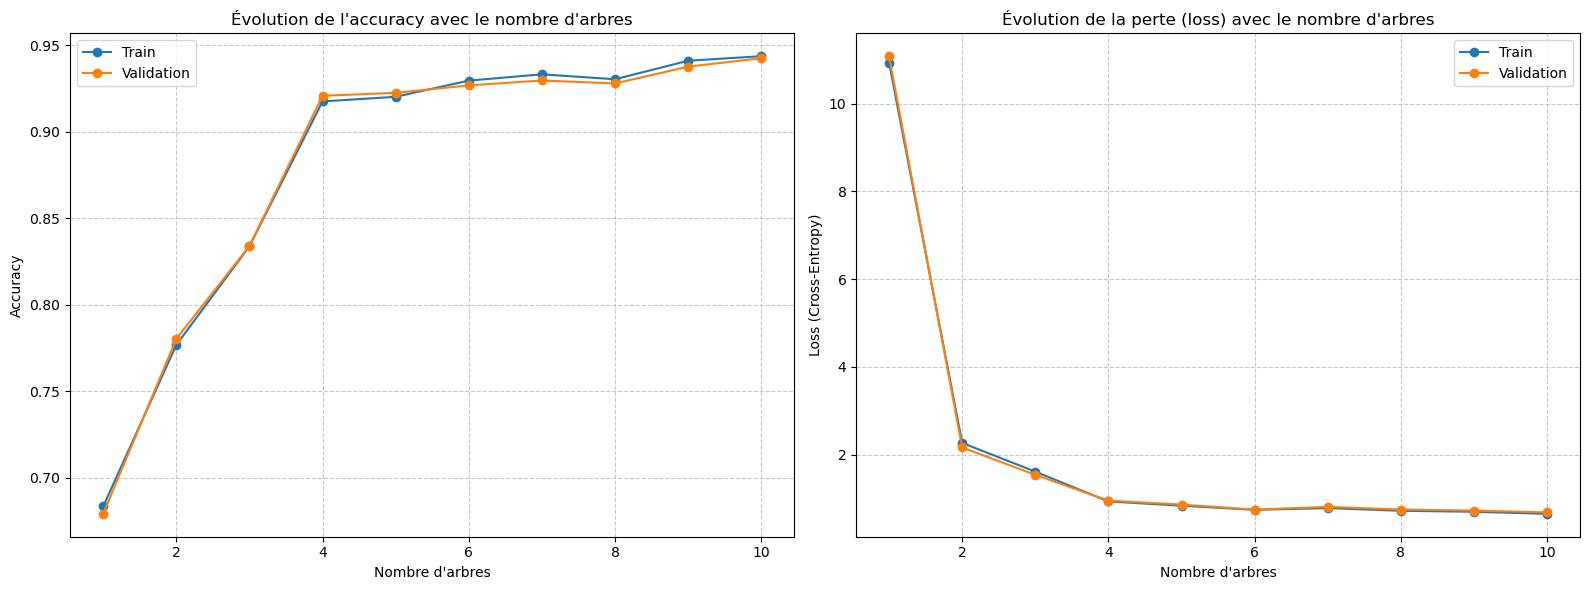

In [ ]:
plt.figure(figsize=(16, 6))

# Courbe d'accuracy
plt.subplot(1, 2, 1)
plt.plot(rf.history['trees_built'], rf.history['train_accuracy'], '-o', label='Train')
plt.plot(rf.history['trees_built'], rf.history['val_accuracy'], '-o', label='Validation')
plt.title('Évolution de l\'accuracy avec le nombre d\'arbres')
plt.xlabel('Nombre d\'arbres')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Courbe de loss
plt.subplot(1, 2, 2)
plt.plot(rf.history['trees_built'], rf.history['train_loss'], '-o', label='Train')
plt.plot(rf.history['trees_built'], rf.history['val_loss'], '-o', label='Validation')
plt.title('Évolution de la perte (loss) avec le nombre d\'arbres')
plt.xlabel('Nombre d\'arbres')
plt.ylabel('Loss (Cross-Entropy)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig('learning_curves_rf_from_scratch.png')
plt.show()



#### Matrice de confusion avec normalisation

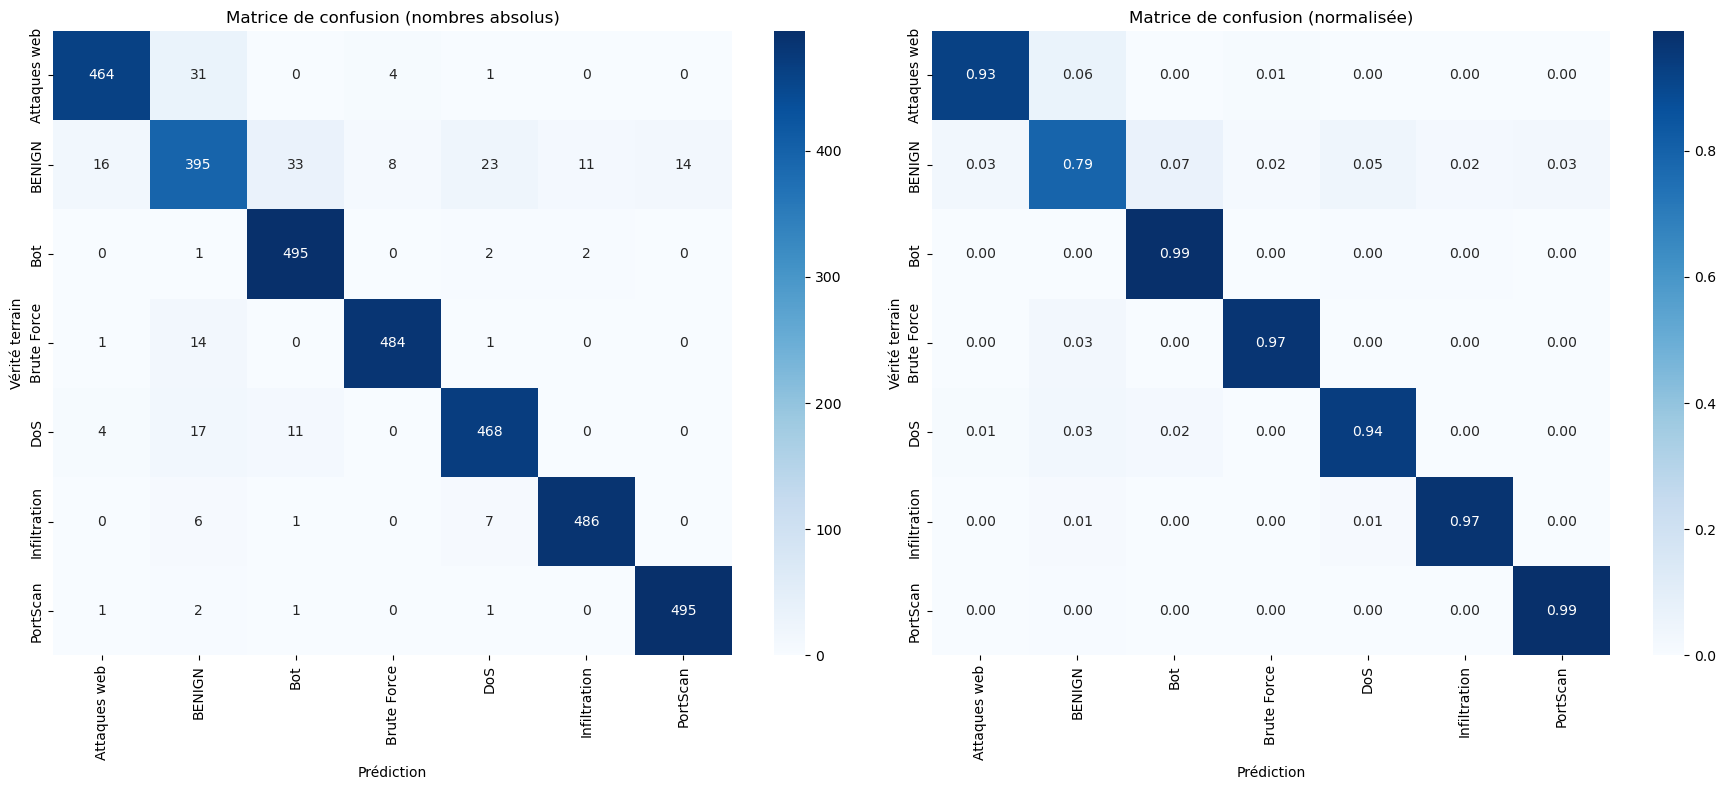

In [ ]:
plt.figure(figsize=(18, 8))

# Matrice brute
plt.subplot(1, 2, 1)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion (nombres absolus)')

# Matrice normalisée
plt.subplot(1, 2, 2)
conf_matrix_norm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion (normalisée)')

plt.tight_layout()
plt.savefig('confusion_matrices_rf_from_scratch.png')
plt.show()

#### Distribution des probabilités prédites par classe

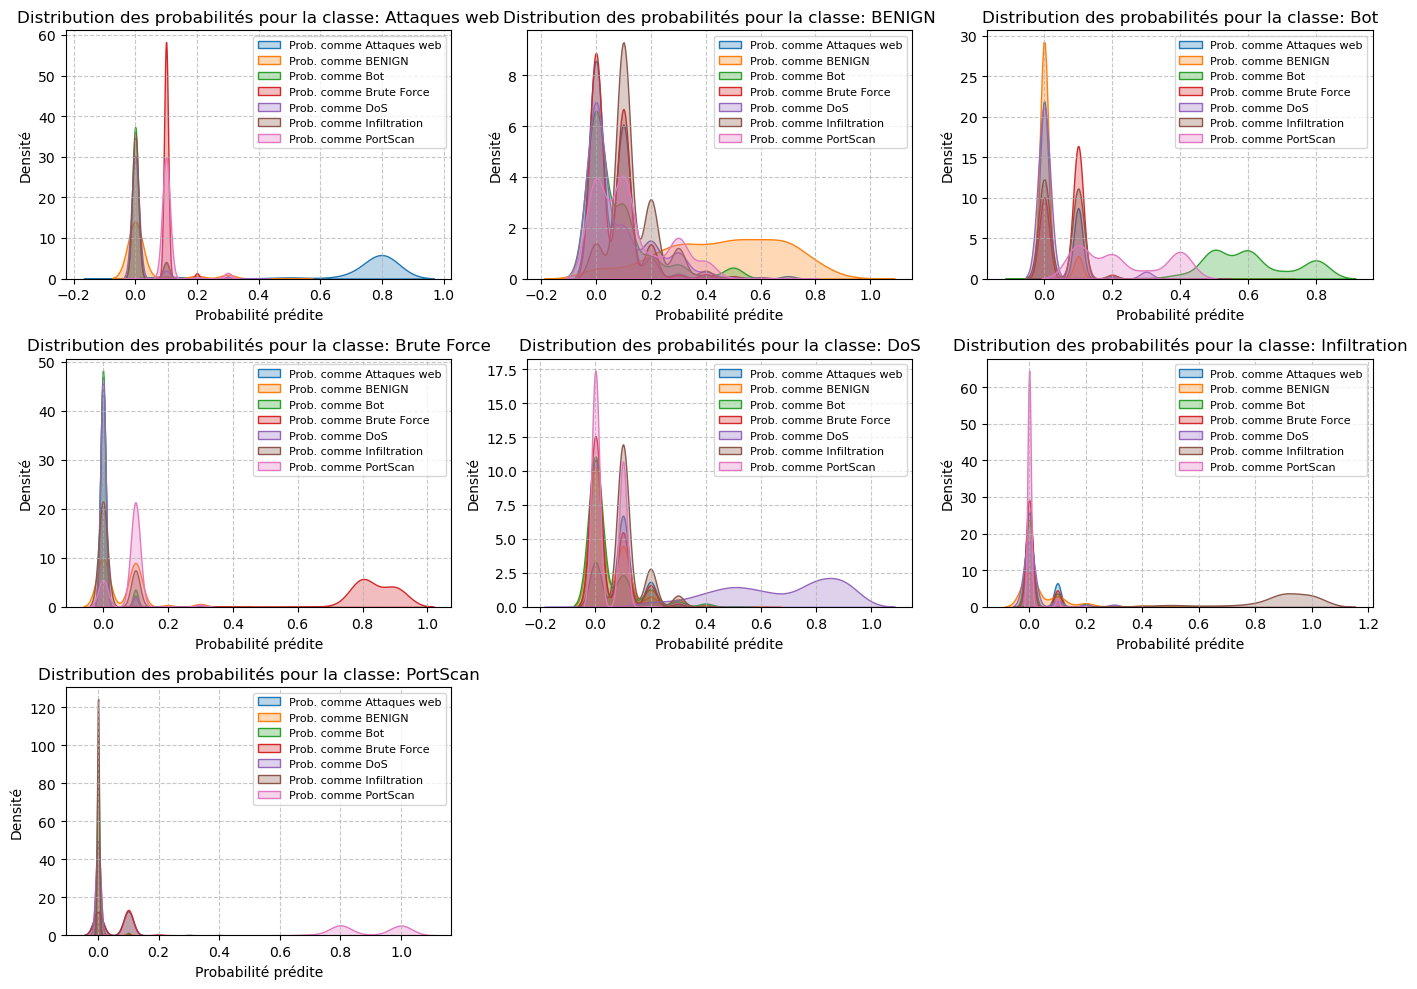

In [ ]:
plt.figure(figsize=(14, 10))

n_classes = len(label_encoder.classes_)
n_cols = 3
n_rows = (n_classes + n_cols - 1) // n_cols

for i, class_name in enumerate(label_encoder.classes_):
    plt.subplot(n_rows, n_cols, i+1)
    class_indices = (y_test == i)
    if np.sum(class_indices) > 0:  
        for j, target_name in enumerate(label_encoder.classes_):
            probs = y_pred_proba[class_indices, j]
            if len(probs) > 0:
                sns.kdeplot(probs, label=f'Prob. comme {target_name}', fill=True, alpha=0.3)
        
        plt.title(f'Distribution des probabilités pour la classe: {class_name}')
        plt.xlabel('Probabilité prédite')
        plt.ylabel('Densité')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(prop={'size': 8})

plt.tight_layout()
plt.savefig('probability_distributions_rf_from_scratch.png')
plt.show()


 Mesure de stabilité du modèle - Variation de performance par classe 

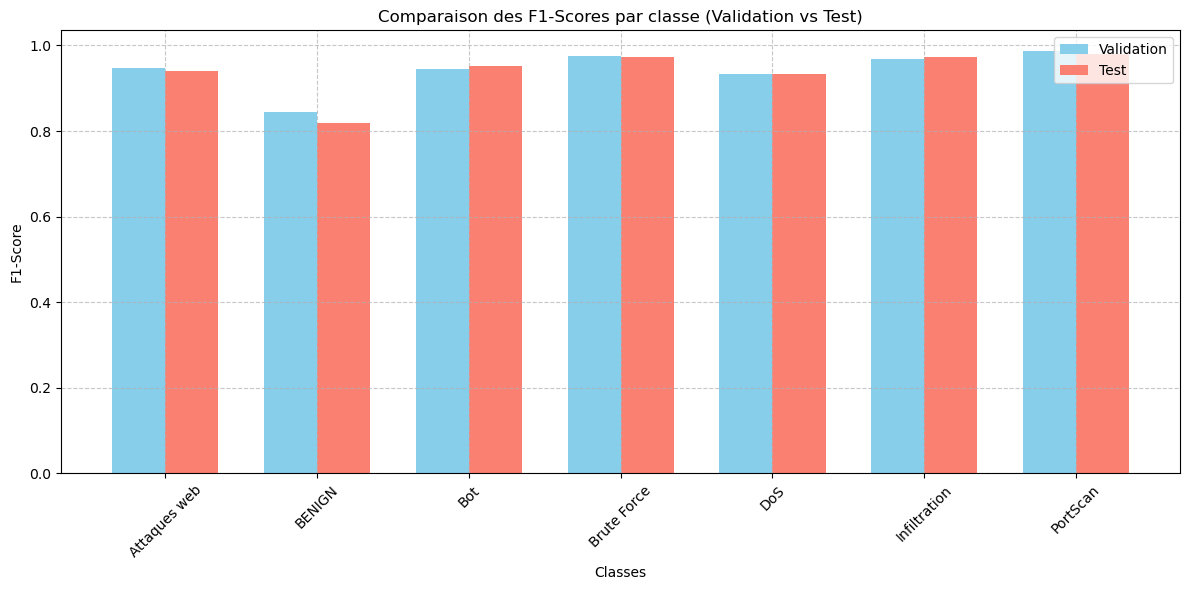

In [ ]:
val_pred = rf.predict(X_val)
test_pred = rf.predict(X_test)

val_report = classification_report(y_val, val_pred, target_names=label_encoder.classes_, output_dict=True)
test_report = classification_report(y_test, test_pred, target_names=label_encoder.classes_, output_dict=True)

val_f1 = {cls: val_report[cls]['f1-score'] for cls in label_encoder.classes_}
test_f1 = {cls: test_report[cls]['f1-score'] for cls in label_encoder.classes_}

plt.figure(figsize=(12, 6))
bar_width = 0.35
r1 = np.arange(len(label_encoder.classes_))
r2 = [x + bar_width for x in r1]

plt.bar(r1, list(val_f1.values()), width=bar_width, label='Validation', color='skyblue')
plt.bar(r2, list(test_f1.values()), width=bar_width, label='Test', color='salmon')

plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title('Comparaison des F1-Scores par classe (Validation vs Test)')
plt.xticks([r + bar_width/2 for r in range(len(label_encoder.classes_))], label_encoder.classes_, rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('f1_score_comparison_rf_from_scratch.png')
plt.show()


 Visualisation de l'entropie des prédictions (mesure d'incertitude)

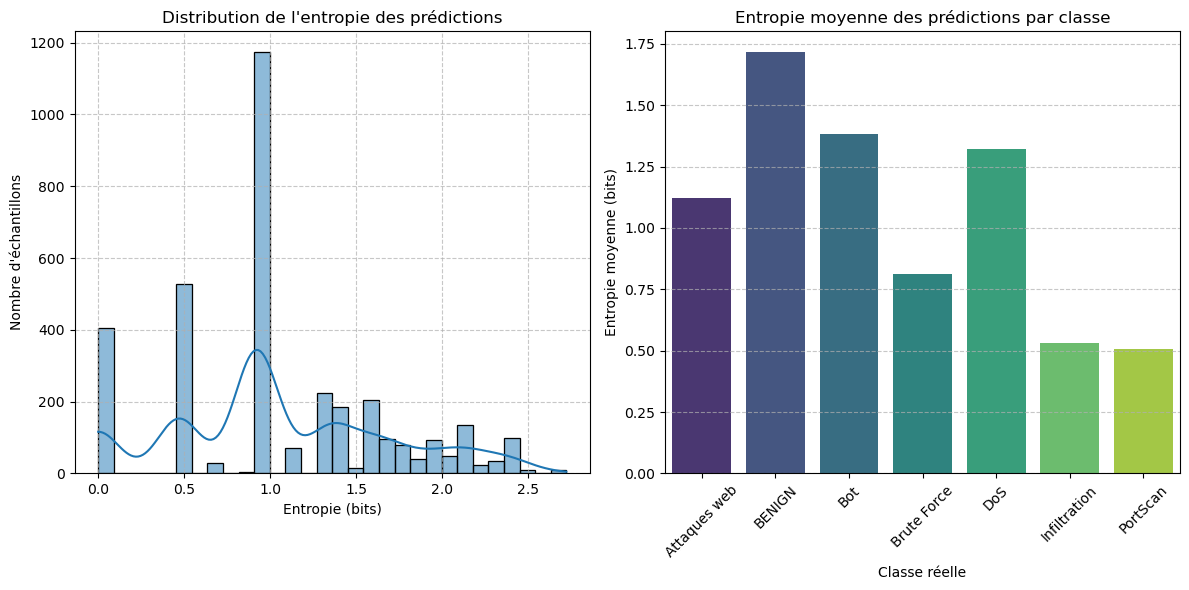

In [ ]:
def prediction_entropy(probs):
    """Calcule l'entropie des probabilités prédites"""
    return entropy(probs, base=2, axis=1)
test_entropies = prediction_entropy(y_pred_proba)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(test_entropies, kde=True, bins=30)
plt.title('Distribution de l\'entropie des prédictions')
plt.xlabel('Entropie (bits)')
plt.ylabel('Nombre d\'échantillons')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
class_entropies = {}
for i, class_name in enumerate(label_encoder.classes_):
    class_indices = (y_test == i)
    if np.sum(class_indices) > 0:
        class_entropies[class_name] = np.mean(test_entropies[class_indices])

classes, entropy_values = zip(*class_entropies.items())
sns.barplot(x=list(classes), y=list(entropy_values), palette='viridis')
plt.title('Entropie moyenne des prédictions par classe')
plt.xlabel('Classe réelle')
plt.ylabel('Entropie moyenne (bits)')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('prediction_entropy_rf_from_scratch.png')
plt.show()


Analyse des erreurs de classification

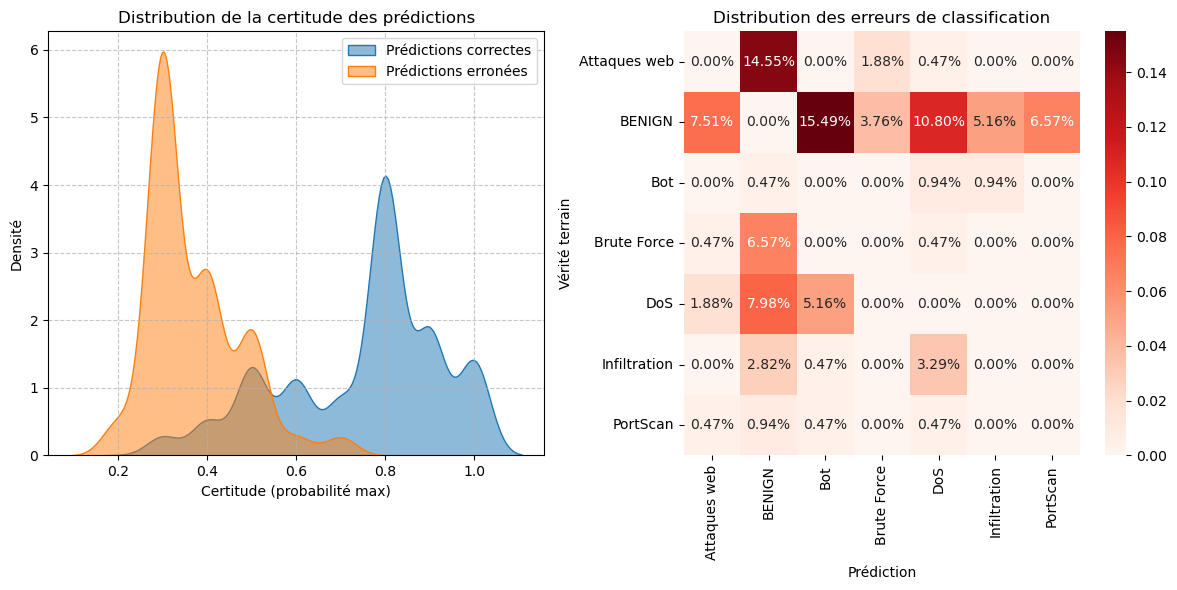


Top 5 des erreurs de classification les plus fréquentes:
Vrai: BENIGN, Prédit: Bot - 33 occurrences (15.49% des erreurs)
Vrai: Attaques web, Prédit: BENIGN - 31 occurrences (14.55% des erreurs)
Vrai: BENIGN, Prédit: DoS - 23 occurrences (10.80% des erreurs)
Vrai: DoS, Prédit: BENIGN - 17 occurrences (7.98% des erreurs)
Vrai: BENIGN, Prédit: Attaques web - 16 occurrences (7.51% des erreurs)


In [ ]:
error_indices = np.where(y_test != y_pred)[0]
correct_indices = np.where(y_test == y_pred)[0]

if len(error_indices) > 0:
    error_certainty = np.max(y_pred_proba[error_indices], axis=1)
    correct_certainty = np.max(y_pred_proba[correct_indices], axis=1)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.kdeplot(correct_certainty, label='Prédictions correctes', fill=True, alpha=0.5)
    sns.kdeplot(error_certainty, label='Prédictions erronées', fill=True, alpha=0.5)
    plt.title('Distribution de la certitude des prédictions')
    plt.xlabel('Certitude (probabilité max)')
    plt.ylabel('Densité')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    error_confusion = np.zeros((len(label_encoder.classes_), len(label_encoder.classes_)))
    for i in error_indices:
        true_label = y_test[i]
        pred_label = y_pred[i]
        error_confusion[true_label, pred_label] += 1
        
    error_sum = np.sum(error_confusion)
    if error_sum > 0:
        error_confusion = error_confusion / error_sum
    
    sns.heatmap(error_confusion, annot=True, fmt='.2%', cmap='Reds',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité terrain')
    plt.title('Distribution des erreurs de classification')
    
    plt.tight_layout()
    plt.savefig('error_analysis_rf_from_scratch.png')
    plt.show()
    
    error_counts = {}
    for i in error_indices:
        true_label = y_test[i]
        pred_label = y_pred[i]
        error_pair = (label_encoder.classes_[true_label], label_encoder.classes_[pred_label])
        if error_pair in error_counts:
            error_counts[error_pair] += 1
        else:
            error_counts[error_pair] = 1

    top_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print("\nTop 5 des erreurs de classification les plus fréquentes:")
    for (true_label, pred_label), count in top_errors:
        percentage = (count / len(error_indices)) * 100
        print(f"Vrai: {true_label}, Prédit: {pred_label} - {count} occurrences ({percentage:.2f}% des erreurs)")


Analyse des performances par nombre d'arbres (pour comprendre le point optimal)

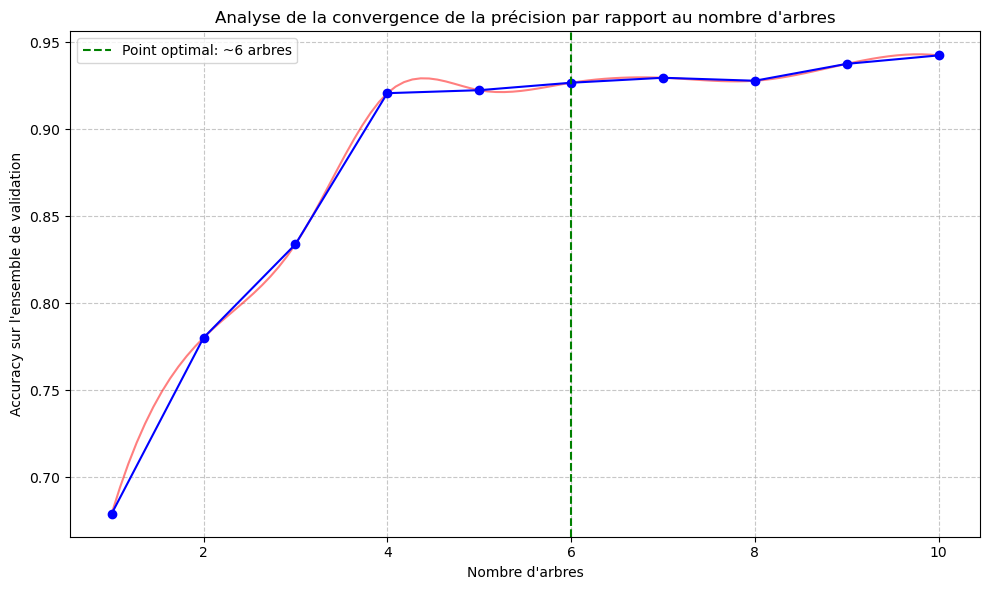


D'après l'analyse de convergence, le nombre optimal d'arbres serait d'environ 6.


In [ ]:
plt.figure(figsize=(10, 6))

xpoints = rf.history['trees_built']
ypoints = rf.history['val_accuracy']

# Interpoler pour estimer les valeurs à tous les points (pour une courbe lisse)
from scipy.interpolate import interp1d
if len(xpoints) > 3:  
    xpoints_unique = np.unique(xpoints)  
    if len(xpoints_unique) > 3:
        x_interp = np.linspace(min(xpoints_unique), max(xpoints_unique), 100)
        f = interp1d(xpoints_unique, [ypoints[i] for i in range(len(xpoints)) if xpoints[i] in xpoints_unique], kind='cubic')
        y_interp = f(x_interp)
        
        # Calculer la dérivée pour identifier le point de stabilisation
        dx = np.gradient(x_interp)
        dy = np.gradient(y_interp)
        slopes = dy / dx
        
        # Trouver le point où la pente devient inférieure à un seuil
        threshold = 0.001  # Seuil pour considérer que la courbe s'est stabilisée
        stabilization_points = np.where(np.abs(slopes) < threshold)[0]
        
        if len(stabilization_points) > 0:
            optimal_trees = int(x_interp[stabilization_points[0]])
        else:
            optimal_trees = int(max(xpoints))
        
        plt.plot(x_interp, y_interp, 'r-', alpha=0.5)
        plt.plot(xpoints, ypoints, 'bo-')
        plt.axvline(x=optimal_trees, color='g', linestyle='--', 
                   label=f'Point optimal: ~{optimal_trees} arbres')
    else:
        plt.plot(xpoints, ypoints, 'bo-')
        optimal_trees = int(max(xpoints))
else:
    plt.plot(xpoints, ypoints, 'bo-')
    optimal_trees = int(max(xpoints))

plt.title('Analyse de la convergence de la précision par rapport au nombre d\'arbres')
plt.xlabel('Nombre d\'arbres')
plt.ylabel('Accuracy sur l\'ensemble de validation')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('convergence_analysis_rf_from_scratch.png')
plt.show()

print(f"\nD'après l'analyse de convergence, le nombre optimal d'arbres serait d'environ {optimal_trees}.")



Affichage des résultats finaux

In [17]:
print("\n=== Résultats finaux du modèle RandomForest From Scratch ===")
print(f"Accuracy globale sur l'ensemble de test: {accuracy:.4f}")
print(f"Nombre optimal d'arbres recommandé: {optimal_trees}")
print(f"Caractéristique la plus importante: {top_features.index[0]} (importance: {top_features.iloc[0]:.4f})")
print(f"Temps d'entraînement total: {training_time:.2f} secondes")

class_accuracies = {}
for i, class_name in enumerate(label_encoder.classes_):
    class_indices = (y_test == i)
    class_correct = np.sum((y_test[class_indices] == y_pred[class_indices]))
    class_accuracies[class_name] = class_correct / np.sum(class_indices)

print("\nAccuracy par classe:")
for cls, acc in class_accuracies.items():
    print(f"{cls}: {acc:.4f}")

print("\nRésumé des performances par classe:")
for cls in label_encoder.classes_:
    precision = test_report[cls]['precision']
    recall = test_report[cls]['recall']
    f1 = test_report[cls]['f1-score']
    support = test_report[cls]['support']
    print(f"{cls}: Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}, Support={support}")

def prediction_entropy(probs):
    """Calcule l'entropie des probabilités prédites"""
    return entropy(probs, base=2, axis=1)


=== Résultats finaux du modèle RandomForest From Scratch ===
Accuracy globale sur l'ensemble de test: 0.9391
Nombre optimal d'arbres recommandé: 6
Caractéristique la plus importante: Total Fwd Packets (importance: 0.1360)
Temps d'entraînement total: 44.49 secondes

Accuracy par classe:
Attaques web: 0.9280
BENIGN: 0.7900
Bot: 0.9900
Brute Force: 0.9680
DoS: 0.9360
Infiltration: 0.9720
PortScan: 0.9900

Résumé des performances par classe:
Attaques web: Precision=0.9547, Recall=0.9280, F1-Score=0.9412, Support=500.0
BENIGN: Precision=0.8476, Recall=0.7900, F1-Score=0.8178, Support=500.0
Bot: Precision=0.9150, Recall=0.9900, F1-Score=0.9510, Support=500.0
Brute Force: Precision=0.9758, Recall=0.9680, F1-Score=0.9719, Support=500.0
DoS: Precision=0.9304, Recall=0.9360, F1-Score=0.9332, Support=500.0
Infiltration: Precision=0.9739, Recall=0.9720, F1-Score=0.9730, Support=500.0
PortScan: Precision=0.9725, Recall=0.9900, F1-Score=0.9812, Support=500.0
